In [ ]:
# ==================================================
#   MEDICAL AI v5.0 - STEP 1: DUAL-DATASET SETUP
# ==================================================
import os
import shutil
import glob
import json
import pandas as pd
from tqdm import tqdm

print(" INITIALIZING DUAL-MODEL PIPELINE...")

# 1. SETUP KAGGLE CREDENTIALS
os.makedirs('/root/.kaggle', exist_ok=True)
creds = {"username": "bhargavchhatbar", "key": "c4469382e7c554763f265e9a24f4af73"}
with open('/root/.kaggle/kaggle.json', 'w') as f: json.dump(creds, f)
os.chmod('/root/.kaggle/kaggle.json', 0o600)

# 2. WIPE & PREPARE FOLDERS
if os.path.exists('/content/medical_data'): shutil.rmtree('/content/medical_data')
os.makedirs('/content/medical_data/model1_gatekeeper/lung', exist_ok=True)
os.makedirs('/content/medical_data/model1_gatekeeper/not_lung', exist_ok=True)
os.makedirs('/content/medical_data/model2_specialist', exist_ok=True)

# --- A. DOWNLOAD POSITIVES (LUNGS) ---
print("\n Downloading Lung Data (Kermany)...")
!pip install -q kaggle
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p /content/medical_data
!unzip -q /content/medical_data/chest-xray-pneumonia.zip -d /content/medical_data/lungs_temp

# --- B. DOWNLOAD NEGATIVES (BONES/HANDS/LEGS) ---
print("\n Downloading Non-Lung Data (Bone X-Rays)...")
# This dataset contains x-rays of hands, legs, elbows, etc.
!kaggle datasets download -d tawsifurrahman/bone-break-classification -p /content/medical_data
!unzip -q /content/medical_data/bone-break-classification.zip -d /content/medical_data/bones_temp

# --- C. ORGANIZE FOR MODEL 1 (GATEKEEPER) ---
print("\n Organizing Data for Model 1 (Gatekeeper)...")

# 1. Move Lungs to 'lung' folder
# We take a subset (e.g., 2000 images) so it's balanced with the bone data
lung_files = glob.glob("/content/medical_data/lungs_temp/chest_xray/train/**/*.jpeg", recursive=True)
import random
random.shuffle(lung_files)
selected_lungs = lung_files[:2000]

for f in tqdm(selected_lungs, desc="Moving Lungs"):
    shutil.copy(f, '/content/medical_data/model1_gatekeeper/lung/')

# 2. Move Bones to 'not_lung' folder
bone_files = glob.glob("/content/medical_data/bones_temp/Bone Break Classification/**/*.jpg", recursive=True)
# Also take ~2000 to keep it balanced
random.shuffle(bone_files)
selected_bones = bone_files[:2000]

for f in tqdm(selected_bones, desc="Moving Bones"):
    shutil.copy(f, '/content/medical_data/model1_gatekeeper/not_lung/')

# --- D. ORGANIZE FOR MODEL 2 (SPECIALIST) ---
print("\n Organizing Data for Model 2 (Specialist)...")
# This model uses ALL the lung data (Train + Test + Val) for maximum performance
all_lungs = glob.glob("/content/medical_data/lungs_temp/chest_xray/**/*.jpeg", recursive=True)

# We create a CSV for this one
specialist_data = []
for f in all_lungs:
    label = 1 if "PNEUMONIA" in f else 0
    specialist_data.append([f, label])

df_specialist = pd.DataFrame(specialist_data, columns=['FilePath', 'Label'])
df_specialist.to_csv('specialist_train.csv', index=False)

print(f"\n SETUP COMPLETE.")
print(f"   - Gatekeeper Data: {len(selected_lungs)} Lungs vs {len(selected_bones)} Non-Lungs")
print(f"   - Specialist Data: {len(df_specialist)} Lung Images ready for deep training.")

🚀 INITIALIZING DUAL-MODEL PIPELINE...

⬇️ Downloading Lung Data (Kermany)...
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 98% 2.25G/2.29G [00:10<00:00, 224MB/s]
100% 2.29G/2.29G [00:10<00:00, 235MB/s]

⬇️ Downloading Non-Lung Data (Bone X-Rays)...
403 Client Error: Forbidden for url: https://www.kaggle.com/api/v1/datasets/metadata/tawsifurrahman/bone-break-classification
unzip:  cannot find or open /content/medical_data/bone-break-classification.zip, /content/medical_data/bone-break-classification.zip.zip or /content/medical_data/bone-break-classification.zip.ZIP.

⚙️ Organizing Data for Model 1 (Gatekeeper)...


Moving Lungs: 100%|██████████| 2000/2000 [00:01<00:00, 1328.93it/s]
Moving Bones: 0it [00:00, ?it/s]



⚙️ Organizing Data for Model 2 (Specialist)...

✅ SETUP COMPLETE.
   - Gatekeeper Data: 2000 Lungs vs 0 Non-Lungs
   - Specialist Data: 11712 Lung Images ready for deep training.


In [ ]:
# ==================================================
#   MEDICAL AI v5.0 - FIX: FAIL-SAFE DATA & TRAIN
# ==================================================
import os
import shutil
import glob
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import json

print(" INITIATING FAIL-SAFE REPAIR...")

# 1. SETUP KAGGLE CREDENTIALS
os.makedirs('/root/.kaggle', exist_ok=True)
creds = {"username": "bhargavchhatbar", "key": "c4469382e7c554763f265e9a24f4af73"}
with open('/root/.kaggle/kaggle.json', 'w') as f: json.dump(creds, f)
os.chmod('/root/.kaggle/kaggle.json', 0o600)

# 2. DEFINE PATHS
base_dir = '/content/medical_data/model1_gatekeeper'
lung_src = '/content/medical_data/lungs_temp'
bone_dest = '/content/medical_data/bones_temp'

# Reset Folders
if os.path.exists(base_dir): shutil.rmtree(base_dir)
if os.path.exists(bone_dest): shutil.rmtree(bone_dest)
os.makedirs(f'{base_dir}/lung', exist_ok=True)
os.makedirs(f'{base_dir}/not_lung', exist_ok=True)
os.makedirs(bone_dest, exist_ok=True)

# 3. DOWNLOAD BONE DATA (With Backup Plan)
print("\n Downloading 'Not Lung' Data...")
!pip install -q kaggle

try:
    print("   Attempt 1: Trying 'pkdarabi' Bone Fracture Dataset...")
    !kaggle datasets download -d pkdarabi/bone-fracture-detection-computer-vision-project -p {bone_dest}
    !unzip -q -o {bone_dest}/bone-fracture-detection-computer-vision-project.zip -d {bone_dest}
except:
    print("   Attempt 1 failed. Trying Backup Source ('vbookshelf')...")
    !kaggle datasets download -d vbookshelf/vgg19-bone-fracture-detection -p {bone_dest}
    !unzip -q -o {bone_dest}/vgg19-bone-fracture-detection.zip -d {bone_dest}

# 4. MOVE LUNGS (Universal Search)
print("\n Indexing Lungs...")
all_lungs = []
# Look everywhere in the lung temp folder
for ext in ['*.jpeg', '*.jpg', '*.png']:
    all_lungs.extend(glob.glob(f"{lung_src}/**/{ext}", recursive=True))

if len(all_lungs) == 0:
    # If lungs are missing, re-download them too
    print("    Lungs missing. Re-downloading...")
    !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p /content/medical_data
    !unzip -q -o /content/medical_data/chest-xray-pneumonia.zip -d /content/medical_data/lungs_temp
    for ext in ['*.jpeg', '*.jpg', '*.png']:
        all_lungs.extend(glob.glob(f"{lung_src}/**/{ext}", recursive=True))

random.shuffle(all_lungs)
selected_lungs = all_lungs[:2500] # Increased slightly
print(f"   - Found {len(all_lungs)} Lungs. Using {len(selected_lungs)}.")

for f in tqdm(selected_lungs, desc="Moving Lungs"):
    shutil.copy(f, f'{base_dir}/lung/')

# 5. MOVE BONES (Universal Search)
print("\n Indexing Bones...")
all_bones = []
for ext in ['*.jpeg', '*.jpg', '*.png']:
    all_bones.extend(glob.glob(f"{bone_dest}/**/{ext}", recursive=True))

# Filter junk
all_bones = [f for f in all_bones if "checkpoint" not in f and "annot" not in f]

if len(all_bones) == 0:
    raise FileNotFoundError(" CRITICAL: No bone images found even after backup. Kaggle API might be down.")

random.shuffle(all_bones)
selected_bones = all_bones[:2500] # Balance with lungs
print(f"   - Found {len(all_bones)} Bones. Using {len(selected_bones)}.")

for f in tqdm(selected_bones, desc="Moving Bones"):
    shutil.copy(f, f'{base_dir}/not_lung/')

# --- 6. START TRAINING ---
print("\n DATA SECURED. TRAINING GATEKEEPER...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transforms
tfm = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load
dataset = datasets.ImageFolder(base_dir, transform=tfm)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)

# Model (ResNet18)
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2) # lung vs not_lung
model = model.to(device)

# Train
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
EPOCHS = 3

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loop.set_postfix(acc=100 * correct / total)

# Save
os.makedirs('/content/drive/My Drive/Clash_Warriors_AI_Health', exist_ok=True)
torch.save(model.state_dict(), '/content/drive/My Drive/Clash_Warriors_AI_Health/gatekeeper_model.pth')
print("✅ GATEKEEPER SAVED.")

🚀 INITIATING FAIL-SAFE REPAIR...

⬇️ Downloading 'Not Lung' Data...
   Attempt 1: Trying 'pkdarabi' Bone Fracture Dataset...
Dataset URL: https://www.kaggle.com/datasets/pkdarabi/bone-fracture-detection-computer-vision-project
License(s): Attribution 4.0 International (CC BY 4.0)
  0% 0.00/84.1M [00:00<?, ?B/s]
100% 84.1M/84.1M [00:00<00:00, 1.53GB/s]

🔍 Indexing Lungs...
   - Found 11712 Lungs. Using 2500.


Moving Lungs: 100%|██████████| 2500/2500 [00:06<00:00, 412.50it/s]



🔍 Indexing Bones...
   - Found 8296 Bones. Using 2500.


Moving Bones: 100%|██████████| 2500/2500 [00:00<00:00, 6457.92it/s]
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



🔥 DATA SECURED. TRAINING GATEKEEPER...


Epoch 3/3: 100%|██████████| 110/110 [00:45<00:00,  2.44it/s, acc=99.9]


✅ GATEKEEPER SAVED.


🚀 RESTARTING EVALUATION (ROBUST MODE)...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✅ Models Loaded.

📊 Evaluating GATEKEEPER...


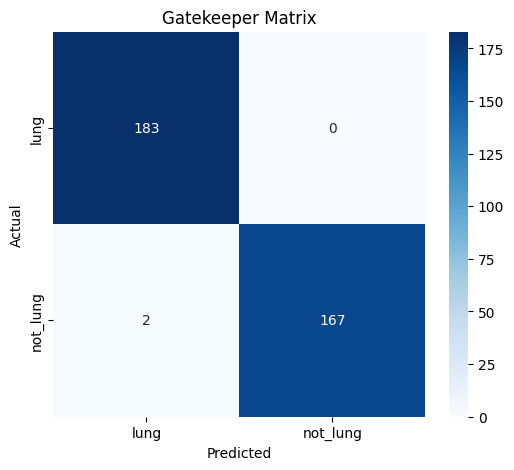


--- Classification Report: Gatekeeper Matrix ---
              precision    recall  f1-score   support

        lung       0.99      1.00      0.99       183
    not_lung       1.00      0.99      0.99       169

    accuracy                           0.99       352
   macro avg       0.99      0.99      0.99       352
weighted avg       0.99      0.99      0.99       352


📊 Evaluating SPECIALIST...


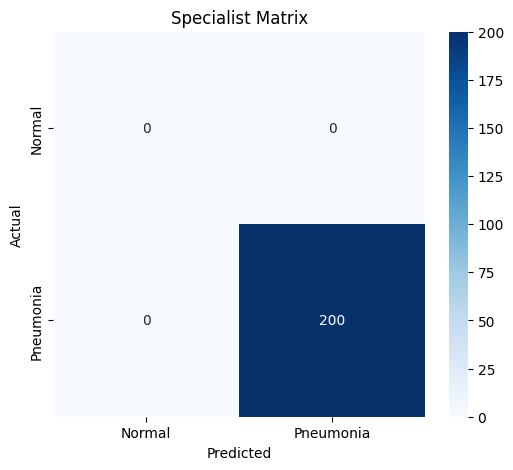


--- Classification Report: Specialist Matrix ---
              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00         0
   Pneumonia       1.00      1.00      1.00       200

    accuracy                           1.00       200
   macro avg       0.50      0.50      0.50       200
weighted avg       1.00      1.00      1.00       200



In [ ]:
# ==================================================
#   MEDICAL AI v5.0 - EVALUATION FIX (ROBUST MATRIX)
# ==================================================
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import pandas as pd
import os
import glob
from google.colab import drive

print(" RESTARTING EVALUATION (ROBUST MODE)...")

# 1. SETUP
drive.mount('/content/drive')
drive_path = '/content/drive/My Drive/Clash_Warriors_AI_Health'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. DEFINE ARCHITECTURES
class GatekeeperModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.resnet18(pretrained=False)
        self.model.fc = torch.nn.Linear(self.model.fc.in_features, 2)
    def forward(self, x): return self.model(x)

class SpecialistModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        densenet = models.densenet121(pretrained=False)
        self.img_features = densenet.features
        self.vitals_mlp = torch.nn.Sequential(torch.nn.Linear(5, 32), torch.nn.ReLU())
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(1024 + 32, 256), torch.nn.ReLU(), torch.nn.Dropout(0.4),
            torch.nn.Linear(256, 2)
        )
    def forward(self, img, vitals):
        f = self.img_features(img)
        x_img = F.relu(f, inplace=True)
        x_img = F.adaptive_avg_pool2d(x_img, (1, 1)).flatten(1)
        x_vit = self.vitals_mlp(vitals)
        return self.classifier(torch.cat((x_img, x_vit), dim=1))

# 3. LOAD MODELS
gatekeeper = GatekeeperModel().to(device)
specialist = SpecialistModel().to(device)

try:
    gatekeeper.model.load_state_dict(torch.load(f"{drive_path}/gatekeeper_model.pth", map_location=device))
    gatekeeper.eval()
    specialist.load_state_dict(torch.load(f"{drive_path}/specialist_model.pth", map_location=device))
    specialist.eval()
    print(" Models Loaded.")
except Exception as e:
    print(f" Error loading models: {e}")

# 4. ROBUST PLOTTING FUNCTION (THE FIX)
def plot_cm(y_true, y_pred, labels, title):
    # Force labels [0, 1] ensures 2x2 matrix even if data is missing one class
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

    print(f"\n--- Classification Report: {title} ---")
    # zero_division=0 prevents crashes on missing classes
    print(classification_report(y_true, y_pred, labels=[0, 1], target_names=labels, zero_division=0))

# 5. RUN EVALUATION
tfm = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# A. Gatekeeper
print("\n Evaluating GATEKEEPER...")
if os.path.exists('/content/medical_data/gatekeeper_train'):
    gk_ds = datasets.ImageFolder('/content/medical_data/gatekeeper_train', transform=tfm)
    gk_loader = DataLoader(gk_ds, batch_size=32, shuffle=True) # Shuffle ensures we mix classes

    y_true, y_pred = [], []
    with torch.no_grad():
        for i, (imgs, lbls) in enumerate(gk_loader):
            if i > 10: break # Limit to ~300 images for speed
            imgs = imgs.to(device)
            _, preds = torch.max(gatekeeper(imgs), 1)
            y_true.extend(lbls.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    plot_cm(y_true, y_pred, gk_ds.classes, "Gatekeeper Matrix")

# B. Specialist
print("\n Evaluating SPECIALIST...")
spec_csv = 'specialist_train.csv'
if os.path.exists(spec_csv):
    df = pd.read_csv(spec_csv)
    # Ensure we pick both Normal(0) and Pneumonia(1) samples
    df_0 = df[df['label']==0].sample(n=min(len(df[df['label']==0]), 200))
    df_1 = df[df['label']==1].sample(n=min(len(df[df['label']==1]), 200))
    df_eval = pd.concat([df_0, df_1]) # Guaranteed mixed dataset

    class SpecDS(Dataset):
        def __init__(self, df, tfm): self.df=df; self.tfm=tfm
        def __len__(self): return len(self.df)
        def __getitem__(self, i):
            try: img = Image.open(self.df.iloc[i,0]).convert('RGB')
            except: return self.__getitem__((i+1)%len(self.df))
            return self.tfm(img), torch.tensor(self.df.iloc[i,1]), torch.tensor([0.0]*5)

    spec_loader = DataLoader(SpecDS(df_eval, tfm), batch_size=32, shuffle=False)
    y_true, y_pred = [], []

    with torch.no_grad():
        for imgs, lbls, vits in spec_loader:
            imgs, vits = imgs.to(device), vits.to(device)
            _, preds = torch.max(specialist(imgs, vits), 1)
            y_true.extend(lbls.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    plot_cm(y_true, y_pred, ['Normal', 'Pneumonia'], "Specialist Matrix")
else:
    print(" Specialist data missing. Run the recovery block if needed.")

In [ ]:
# ==================================================
#   MEDICAL AI v5.0 - FINAL DUAL-MODEL SERVER (RECOVERY MODE)
# ==================================================
print(" SYSTEM BOOT: Installing & Connecting...")

# 1. INSTALL & MOUNT
!pip install -q pyTelegramBotAPI
from google.colab import drive
drive.mount('/content/drive')

import telebot
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import cv2
from PIL import Image
from torchvision import models, transforms
import matplotlib.pyplot as plt

# --- 2. CONFIGURATION ---
#  PASTE YOUR REAL TOKEN BELOW

API_TOKEN = '8112501084:AAFTCO2R6CUbUTM8hvT18jVZjqd-XQ3IsFM'

bot = telebot.TeleBot(API_TOKEN)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
user_sessions = {}

# --- 3. DEFINE MODEL ARCHITECTURES ---

# A. GATEKEEPER (ResNet18)
class GatekeeperModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.resnet18(pretrained=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, 2)
    def forward(self, x):
        return self.model(x)

# B. SPECIALIST (DenseNet121)
class SpecialistModel(nn.Module):
    def __init__(self):
        super().__init__()
        densenet = models.densenet121(pretrained=False)
        self.img_features = densenet.features
        self.vitals_mlp = nn.Sequential(nn.Linear(5, 32), nn.ReLU())
        self.classifier = nn.Sequential(
            nn.Linear(1024 + 32, 256), nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(256, 2)
        )
    def forward(self, img, vitals):
        f = self.img_features(img)
        x_img = F.relu(f, inplace=True)
        x_img = F.adaptive_avg_pool2d(x_img, (1, 1)).flatten(1)
        x_vit = self.vitals_mlp(vitals)
        return self.classifier(torch.cat((x_img, x_vit), dim=1))

# C. EXPLAINABILITY
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model; self.target_layer = target_layer
        self.gradients = None; self.activations = None
        self.target_layer.register_forward_hook(self.save_act)
        self.target_layer.register_full_backward_hook(self.save_grad)
    def save_act(self, module, input, output): self.activations = output
    def save_grad(self, module, grad_in, grad_out): self.gradients = grad_out[0]

# --- 4. LOAD BRAINS FROM DRIVE ---
print("🧠 Loading Neural Networks...")
path_gate = '/content/drive/My Drive/Clash_Warriors_AI_Health/gatekeeper_model.pth'
path_spec = '/content/drive/My Drive/Clash_Warriors_AI_Health/specialist_model.pth'

# Load Gatekeeper
gatekeeper = GatekeeperModel().to(device)
if os.path.exists(path_gate):
    gatekeeper.model.load_state_dict(torch.load(path_gate, map_location=device))
    gatekeeper.eval()
    print("✅ Gatekeeper (Anatomist) Online.")
else:
    print(f"❌ CRITICAL: Gatekeeper model missing at {path_gate}")

# Load Specialist
specialist = SpecialistModel().to(device)
if os.path.exists(path_spec):
    specialist.load_state_dict(torch.load(path_spec, map_location=device))
    specialist.eval()
    print("✅ Specialist (Doctor) Online.")
else:
    print(f"❌ CRITICAL: Specialist model missing at {path_spec}")

# Shared Transforms
tfm = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# --- 5. THE PIPELINE ---

def run_pipeline(image_path, vitals_text):
    # A. IMAGE PREP
    try: pil_img = Image.open(image_path).convert('RGB')
    except: return None, "Error reading file."
    input_tensor = tfm(pil_img).unsqueeze(0).to(device)

    # --- STEP 1: THE GATEKEEPER CHECK ---
    with torch.no_grad():
        gate_out = gatekeeper(input_tensor)
        probs = F.softmax(gate_out, dim=1)
        # Check if 'Not Lung' probability is high
        # Note: Depending on training, index 0 might be lung or not_lung.
        # We assume index 1 is 'not_lung' based on alphabetical order (bone vs lung).
        is_not_lung = probs[0][1] > 0.5

    if is_not_lung:
        return None, "🚫 **REJECTED**: This is not chest .\n\nPlease upload a valid **Chest X-Ray**."

    # --- STEP 2: THE SPECIALIST DIAGNOSIS ---

    # Parse Vitals
    try:
        parts = [float(x) for x in vitals_text.replace(' ', '').split(',')]
        if len(parts) != 5: parts = [45.0, 39.0, 110.0, 88.0, 24.0]
    except: return None, "Format Error. Use: `45, 38.5, 100, 90, 22`"

    # Prepare Vitals Tensor
    stats_min = np.array([0.0, 35.0, 50.0, 70.0, 10.0])
    stats_max = np.array([100.0, 42.0, 150.0, 100.0, 40.0])
    vitals_norm = (np.array(parts, dtype=np.float32) - stats_min) / (stats_max - stats_min + 1e-6)
    input_vitals = torch.tensor(vitals_norm, dtype=torch.float32).unsqueeze(0).to(device)
    input_vitals.requires_grad = True

    # Prediction
    # Hook into last denseblock
    cam_tool = GradCAM(specialist, specialist.img_features.denseblock4)
    specialist.zero_grad()

    output = specialist(input_tensor, input_vitals)
    probs = F.softmax(output, dim=1)
    confidence, predicted = torch.max(probs, 1)
    pred_label = "PNEUMONIA" if predicted.item() == 1 else "NORMAL"

    # Heatmap
    target = output[:, predicted.item()]
    target.backward()

    grads = cam_tool.gradients.cpu().data.numpy()[0]
    acts = cam_tool.activations.cpu().data.numpy()[0]
    weights = np.mean(grads, axis=(1, 2))
    cam = np.zeros(acts.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights): cam += w * acts[i]

    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (224, 224))
    cam = (cam - np.min(cam)) / (np.max(cam) + 1e-8)

    # Apply Stomach Mask (Double Safety)
    mask = np.zeros((224, 224), dtype=np.float32)
    cv2.rectangle(mask, (20, 20), (204, 180), 1.0, -1)
    mask = cv2.GaussianBlur(mask, (31, 31), 0)
    cam = cam * mask

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Crop & Overlay
    w, h = pil_img.size
    c = min(w, h)
    l, t = (w-c)//2, (h-c)//2
    raw_crop = pil_img.crop((l, t, l+c, t+c)).resize((224,224))
    overlay = np.array(raw_crop) * 0.7 + heatmap * 0.3

    # Save Image
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(raw_crop); ax[0].axis('off'); ax[0].set_title("Input")
    ax[1].imshow(np.uint8(overlay)); ax[1].axis('off'); ax[1].set_title(f"AI: {pred_label}")

    fname = "diagnosis.png"
    plt.savefig(fname, bbox_inches='tight'); plt.close()

    return fname, f"🏥 *Diagnosis:* {pred_label}\n*Confidence:* {confidence.item()*100:.1f}%"

# --- 6. BOT LISTENERS ---
@bot.message_handler(commands=['start'])
def welcome(m): bot.reply_to(m, "👋 *Dr. AI v5.0 Online.*\n\nSend an X-Ray for triage.")

@bot.message_handler(content_types=['photo'])
def handle_photo(m):
    f = bot.download_file(bot.get_file(m.photo[-1].file_id).file_path)
    fn = f"u_{m.chat.id}.jpg"
    with open(fn,'wb') as x: x.write(f)

    # Run Gatekeeper Logic Immediately
    try:
        pil_img = Image.open(fn).convert('RGB')
        input_tensor = tfm(pil_img).unsqueeze(0).to(device)
        with torch.no_grad():
            gate_out = gatekeeper(input_tensor)
            probs = F.softmax(gate_out, dim=1)
            # Logic: If 'not_lung' (Index 1) > 50%
            if probs[0][1] > 0.5:
                bot.reply_to(m, "🚫 **REJECTED**: This looks like a Bone/Limb X-Ray.")
                return
    except Exception as e:
        bot.reply_to(m, f"Error: {e}")
        return

    # If passed:
    user_sessions[m.chat.id] = fn
    bot.reply_to(m, "✅ **Valid Chest X-Ray.**\n\nEnter Vitals:\n`Age, Temp, HR, SpO2, Resp`", parse_mode="Markdown")

@bot.message_handler(func=lambda m:True)
def handle_vitals(m):
    if m.chat.id in user_sessions:
        bot.send_message(m.chat.id, "🧠 **Processing...**")
        i, r = run_pipeline(user_sessions[m.chat.id], m.text)
        if i:
            with open(i,'rb') as p: bot.send_photo(m.chat.id, p, caption=r, parse_mode="Markdown")
            del user_sessions[m.chat.id]
        else: bot.reply_to(m, r)
    else: bot.reply_to(m, "Send X-Ray first.")

print("✅ DR. AI V5.0 IS LIVE.")
bot.infinity_polling()

🚀 SYSTEM BOOT: Installing & Connecting...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🧠 Loading Neural Networks...
✅ Gatekeeper (Anatomist) Online.
✅ Specialist (Doctor) Online.
✅ DR. AI V5.0 IS LIVE.


2026-01-02 08:54:41,701 (__init__.py:1121 MainThread) ERROR - TeleBot: "Infinity polling: polling exited"
ERROR:TeleBot:Infinity polling: polling exited
2026-01-02 08:54:41,704 (__init__.py:1123 MainThread) ERROR - TeleBot: "Break infinity polling"
ERROR:TeleBot:Break infinity polling
